In [3]:
from pyspark.sql import SparkSession

# Crear la sesión de Spark con el driver JDBC
spark = SparkSession.builder \
    .appName("SegmentacionClientes") \
    .config("spark.driver.extraClassPath", "/home/jovyan/mssql-jdbc.jar") \
    .getOrCreate()

# Configuración de conexión JDBC
jdbc_url = "jdbc:sqlserver://host.docker.internal:1433;databaseName=HotelDW;encrypt=false;trustServerCertificate=true"

connection_properties = {
    "user": "SA",
    "password": "Admin123",
    "driver": "com.microsoft.sqlserver.jdbc.SQLServerDriver"
}

# Leer la tabla de clientes
clientes_df = spark.read.jdbc(
    url=jdbc_url,
    table="Cliente",
    properties=connection_properties
)

# Mostrar las primeras filas
clientes_df.show(5)


+----------+-------+--------+--------------------+----------------+---------+------------+
|id_cliente| nombre|apellido|               email|fecha_nacimiento|   genero|nacionalidad|
+----------+-------+--------+--------------------+----------------+---------+------------+
|         1|Marisol|    Ríos|marisol_rios@gmai...|      1960-09-02| Femenino|      Brasil|
|         2| Manuel|   Núñez|manuel_nunez@gmai...|      1968-10-30|Masculino|    Colombia|
|         3|  María|Martínez|maria_martinez@ya...|      2003-06-11| Femenino| Reino Unido|
|         4| Carmen|    Díaz|carmen_diaz@gmail...|      1961-04-24| Femenino|   Argentina|
|         5|   Luis|   Mejía|luis_mejia@hotmai...|      1966-02-24|Masculino|    Honduras|
+----------+-------+--------+--------------------+----------------+---------+------------+
only showing top 5 rows



In [8]:
from pyspark.sql.functions import current_date, datediff, floor

clientes_df = clientes_df.withColumn(
    "edad",
    floor(datediff(current_date(), clientes_df["fecha_nacimiento"]) / 365)
)

clientes_df.select("id_cliente", "edad").show(5)


+----------+----+
|id_cliente|edad|
+----------+----+
|         1|  64|
|         2|  56|
|         3|  22|
|         4|  64|
|         5|  59|
+----------+----+
only showing top 5 rows



In [9]:
reservas_df = spark.read.jdbc(
    url=jdbc_url,
    table="Reserva",
    properties=connection_properties
)

pagos_df = spark.read.jdbc(
    url=jdbc_url,
    table="Pago",
    properties=connection_properties
)


In [10]:
reserva_agg = reservas_df.groupBy("id_cliente") \
    .count() \
    .withColumnRenamed("count", "total_reservas")


In [11]:
from pyspark.sql.functions import datediff, avg

reservas_df = reservas_df.withColumn("duracion", datediff("check_out", "check_in"))

duracion_agg = reservas_df.groupBy("id_cliente") \
    .agg(avg("duracion").alias("duracion_promedio"))


In [12]:
pago_agg = pagos_df.groupBy("id_cliente") \
    .sum("monto") \
    .withColumnRenamed("sum(monto)", "total_pagado")


In [13]:
# Unimos todo sobre 'id_cliente'
cliente_seg = clientes_df.select("id_cliente", "edad") \
    .join(reserva_agg, on="id_cliente", how="left") \
    .join(duracion_agg, on="id_cliente", how="left") \
    .join(pago_agg, on="id_cliente", how="left")

cliente_seg.show(5)


+----------+----+--------------+-----------------+------------+
|id_cliente|edad|total_reservas|duracion_promedio|total_pagado|
+----------+----+--------------+-----------------+------------+
|         1|  64|             4|              4.0|     4002.97|
|         6|  15|             7|4.428571428571429|     8080.26|
|         3|  22|             6|              3.5|     5280.76|
|         5|  59|            10|              4.4|     7372.40|
|         4|  64|             6|              4.5|     3970.52|
+----------+----+--------------+-----------------+------------+
only showing top 5 rows



In [14]:
cliente_seg = cliente_seg.fillna({
    "total_reservas": 0,
    "duracion_promedio": 0,
    "total_pagado": 0
})


In [15]:
cliente_seg.select("id_cliente", "edad", "total_reservas", "duracion_promedio", "total_pagado").show()


+----------+----+--------------+------------------+------------+
|id_cliente|edad|total_reservas| duracion_promedio|total_pagado|
+----------+----+--------------+------------------+------------+
|        12|  38|             3|3.6666666666666665|     1765.59|
|         1|  64|             4|               4.0|     4002.97|
|        13|  21|             2|               4.0|      787.26|
|         6|  15|             7| 4.428571428571429|     8080.26|
|        16|  21|             4|              4.25|     3966.77|
|         3|  22|             6|               3.5|     5280.76|
|        20|  58|             4|               4.5|     1673.26|
|         5|  59|            10|               4.4|     7372.40|
|        19|  20|             4|               3.5|     2128.00|
|        15|  54|             4|              4.75|     2909.48|
|         9|  12|             4|              5.25|     2131.03|
|        17|  13|             5|               5.0|     3996.91|
|         4|  64|        

In [16]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.clustering import KMeans

# Preparamos los datos en un solo vector para k-means
assembler = VectorAssembler(
    inputCols=["total_reservas", "duracion_promedio", "total_pagado"],
    outputCol="features"
)
dataset_kmeans = assembler.transform(cliente_seg)


In [17]:
kmeans = KMeans(k=3, seed=1)
modelo_kmeans = kmeans.fit(dataset_kmeans)
resultado = modelo_kmeans.transform(dataset_kmeans)


In [18]:
resultado.select("id_cliente", "edad", "total_reservas", "duracion_promedio", "total_pagado", "prediction").show()


+----------+----+--------------+------------------+------------+----------+
|id_cliente|edad|total_reservas| duracion_promedio|total_pagado|prediction|
+----------+----+--------------+------------------+------------+----------+
|       148|  61|             2|               4.0|     1796.20|         1|
|       463|  17|             3|3.6666666666666665|     3104.28|         2|
|       471|  48|             4|              4.25|     2228.39|         2|
|       496|  17|             5|               3.2|     3625.72|         2|
|       833|  58|             8|               4.0|     7395.97|         0|
|      1088|  61|             6| 5.333333333333333|     4819.88|         0|
|      1238|  19|             4|              4.25|     2935.72|         2|
|      1342|  35|             1|               5.0|      157.21|         1|
|      1580|  64|             5|               3.8|     4034.61|         2|
|      1591|  59|             3|               5.0|     3214.04|         2|
|      1645|

In [19]:
from pyspark.sql.functions import avg, count

resultado.groupBy("prediction").agg(
    count("*").alias("n_clientes"),
    avg("total_reservas").alias("reserva_prom"),
    avg("duracion_promedio").alias("duracion_prom"),
    avg("total_pagado").alias("pago_prom")
).show()


+----------+----------+------------------+------------------+-----------+
|prediction|n_clientes|      reserva_prom|     duracion_prom|  pago_prom|
+----------+----------+------------------+------------------+-----------+
|         1|      7971|1.9188307615104754|3.6940889892527013|1229.069683|
|         2|      8469| 3.901287046876845| 4.008816186765177|3142.079235|
|         0|      3560|  6.08567415730337| 4.005472358477974|5482.271632|
+----------+----------+------------------+------------------+-----------+



In [20]:
resultado_pd = resultado.select(
    "edad", "total_reservas", "duracion_promedio", "total_pagado", "prediction"
).toPandas()


In [21]:
import matplotlib.pyplot as plt
import seaborn as sns


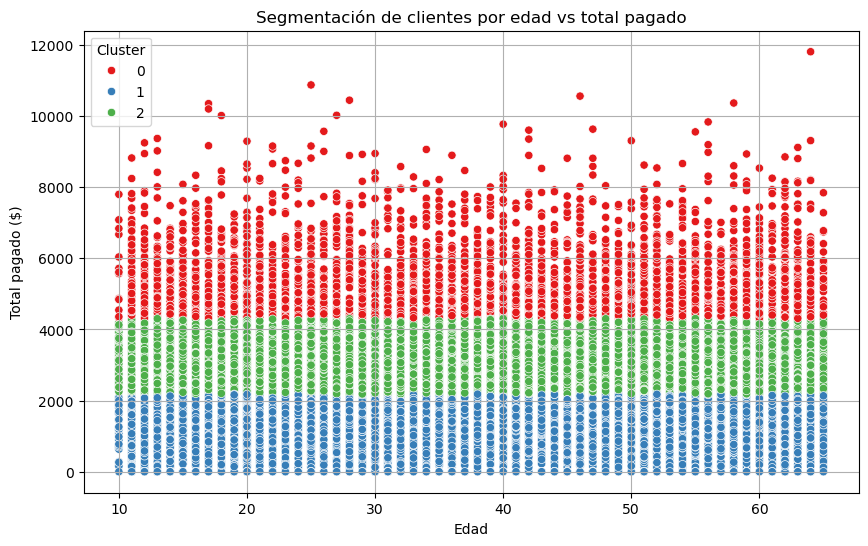

In [22]:
plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=resultado_pd,
    x="edad",
    y="total_pagado",
    hue="prediction",
    palette="Set1"
)
plt.title("Segmentación de clientes por edad vs total pagado")
plt.xlabel("Edad")
plt.ylabel("Total pagado ($)")
plt.legend(title="Cluster")
plt.grid(True)
plt.show()
